# Machine Learning Classifiers
Run several machine learning classifiers (SVM, RF, Logistic Regression) with 24 basic features as well as BOW and TFIDF embedding features. Also calculate feature importance from RF, and feature selection on Logistic Regression

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from myfunctions import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC

# Normalize data function
def normalize_data(X, list_mean=[], list_std=[]):
    nrow, ncol = X.shape
    if len(list_mean) == 0 or len(list_std) == 0:
        x_mean = np.asarray(np.mean(X, axis=0))
        x_std = np.std(X, axis=0)
        list_mean = list(x_mean)
        list_std = list(x_std)
    else:
        x_mean = np.asarray(list_mean)
        x_std = np.asarray(list_std)
    x_mean = x_mean.reshape(1,-1)
    x_std = x_std.reshape(1, -1)
    x_mean = np.repeat(x_mean, nrow, axis=0)
    x_std = np.repeat(x_std, nrow, axis=0)
    X_norm = (X - x_mean) / x_std
    return X_norm, list_mean, list_std

/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Extract Features
This section to extract 24 features from the dataset. Warning: take a while to finish. Therefore I extracted and save into joblib files (Can skip this part)

In [3]:
data_full = pd.read_json('fake_news.json', lines=True)
data_full = data_full.drop(columns=['article_link']) # remove link column
df_train_f, df_test = split_dataframe(data_full, test_size=0.25, seed=1509)
df_train, df_validate = split_dataframe(df_train_f, test_size=0.2, seed=1309)

# Proportion of each subsets
list_label = df_train['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TRAINING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_validate['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== VALIDATING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_test['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TESTING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

data_train = df_train.copy()
data_train_f = df_train_f.copy()
data_val = df_validate.copy()
data_test = df_test.copy()

===== TRAINING SAMPLES =====
Total Sample: 17171
Sarcastic: 8180 (47.64%)
Not Sarcastic: 8991 (52.36%)
===== VALIDATING SAMPLES =====
Total Sample: 4293
Sarcastic: 2045 (47.64%)
Not Sarcastic: 2248 (52.36%)
===== TESTING SAMPLES =====
Total Sample: 7155
Sarcastic: 3409 (47.65%)
Not Sarcastic: 3746 (52.35%)


In [4]:
def extract_feature_basic(data_input):
    '''
    Input: data is the dataframe with only is_sarcastic and headline column
    Output: data with full features (except headline column)
    '''
    data = data_input.copy()
    data['len_headline'] = data.headline.apply(lambda row: count_word(row)) # count words in title
    data['headline_s1'] = data.headline.apply(lambda row: remove_symbol(row))
    data['len_headline_s1'] = data.headline_s1.apply(lambda row: count_word(row))    
    
    data['len_char_s1'] = data.headline_s1.apply(lambda row: len(row))
    data['len_char_headline'] = data.headline.apply(lambda row: len(row))
    data['count_symbol'] = data.len_char_headline - data.len_char_s1
    data['count_symbol_norm'] = data.count_symbol / data.len_char_headline
    
    data['headline_s2'] = data.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
    data['headline_s2'] = data.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))
    data['len_headline_s2'] = data.headline_s2.apply(lambda row: count_word(row))
    data['count_lemmatized'] = count_lemmatized_word(data, 'headline_s1', 'headline_s2')
    data['ratio_lemmatized'] = data['count_lemmatized'] / data['len_headline_s1']
    data['headline_s3'] = data.headline_s2.apply(lambda row: remove_stop_words(row))
    data['len_headline_s3'] = data.headline_s3.apply(lambda row: count_word(row))
    data['numb_stopwords'] = data['len_headline_s2'] - data['len_headline_s3']
    data['ratio_stopwords'] = data['numb_stopwords'] / data['len_headline_s2']
    data['min_len_word'] = data.headline_s1.apply(lambda row: min_len_word(row))
    data['max_len_word'] = data.headline_s1.apply(lambda row: max_len_word(row))
    data['avg_len_word'] = data.headline_s1.apply(lambda row: avg_len_word(row))
    data['max_syl_word'] = data.headline_s1.apply(lambda row: max_syl_word(row))
    data['avg_syl_word'] = data.headline_s1.apply(lambda row: avg_syl_word(row))
    data['numb_syl'] = data.headline_s1.apply(lambda row: count_syllable(row))
    data['norm_numb_syl'] = data.numb_syl / data.len_headline_s1
    data['flesch_grade_score'] = data.headline.apply(lambda row: textstat.flesch_kincaid_grade(row))
    data['ari_score'] = data.headline.apply(lambda row: textstat.automated_readability_index(row))
    data['coleman_score'] = data.headline.apply(lambda row: textstat.coleman_liau_index(row))
    data['linsear_score'] = data.headline.apply(lambda row: textstat.linsear_write_formula(row))
    data['dale_score'] = data.headline.apply(lambda row: textstat.dale_chall_readability_score(row))
    data['standard_score'] = data.headline.apply(lambda row: textstat.text_standard(row, float_output=True))
    data['numb_NN'] = data.headline.apply(lambda row: count_noun(row))
    data['numb_VED'] = data.headline.apply(lambda row: count_verb_past(row))
    data['numb_VB'] = data.headline.apply(lambda row: count_verb_present(row))
    data['numb_VING'] = data.headline.apply(lambda row: count_verb_ing(row))
    data['numb_ADJ'] = data.headline.apply(lambda row: count_adj(row))
    data['numb_ADV'] = data.headline.apply(lambda row: count_adv(row))
    data['numb_DT'] = data.headline.apply(lambda row: count_DT(row))
    data['numb_CD'] = data.headline.apply(lambda row: count_CD(row))
    data['numb_PR'] = data.headline.apply(lambda row: count_pronoun(row))
    data['norm_numb_NN'] = data['numb_NN'] / data['len_headline']
    data['norm_numb_VED'] = data['numb_VED'] / data['len_headline']
    data['norm_numb_VB'] = data['numb_VB'] / data['len_headline']
    data['norm_numb_VING'] = data['numb_VING'] / data['len_headline']
    data['norm_numb_ADJ'] = data['numb_ADJ'] / data['len_headline']
    data['norm_numb_ADV'] = data['numb_ADV'] / data['len_headline']
    data['norm_numb_DT'] = data['numb_DT'] / data['len_headline']
    data['norm_numb_CD'] = data['numb_CD'] / data['len_headline']
    data['norm_numb_PR'] = data['numb_PR'] / data['len_headline']
        
    data_ft = data.drop(columns=['numb_syl', 'count_symbol', 'len_char_s1', 'len_char_headline',
                                 'count_lemmatized', 'numb_stopwords', 'norm_numb_syl',
                                 'len_headline_s1', 'len_headline_s2', 'len_headline_s3', 
                                 'headline', 'headline_s1', 'headline_s2', 'headline_s3', 
                                 'numb_NN', 'numb_VED', 'numb_VB', 'numb_VING', 
                                 'numb_ADJ', 'numb_ADV', 'numb_DT', 'numb_CD', 'numb_PR'])
    
    return data_ft

In [6]:
data_train_ft = extract_feature_basic(data_train)
data_train_ft = extract_feature_basic(data_train_f)
data_val_ft = extract_feature_basic(data_val)
data_test_ft = extract_feature_basic(data_test)

joblib.dump(data_train_ft, 'data_train_basic_ft.joblib')
joblib.dump(data_train_ft, 'data_train_f_basic_ft.joblib')
joblib.dump(data_val_ft, 'data_val_basic_ft.joblib')
joblib.dump(data_test_ft, 'data_test_basic_ft.joblib')

['data_train_f_basic_ft.joblib']

# Prepare Features
Load extracted features from joblib and create X and Y matrix

In [2]:
data_train_f_ft = joblib.load('data_train_f_basic_ft.joblib')
data_train_ft = joblib.load('data_train_basic_ft.joblib')
data_val_ft = joblib.load('data_val_basic_ft.joblib')
data_test_ft = joblib.load('data_test_basic_ft.joblib')

In [3]:
X_train_f = data_train_f_ft.drop(columns=['is_sarcastic'])
y_train_f = data_train_f_ft['is_sarcastic']
X_train_f = np.asarray(X_train_f)
y_train_f = np.asarray(y_train_f)

X_train = data_train_ft.drop(columns=['is_sarcastic'])
y_train = data_train_ft['is_sarcastic']
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_val = data_val_ft.drop(columns=['is_sarcastic'])
y_val = data_val_ft['is_sarcastic']
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

X_test = data_test_ft.drop(columns=['is_sarcastic'])
y_test = data_test_ft['is_sarcastic']
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

feature_names = list(data_val_ft.drop(columns=['is_sarcastic']).columns)

# Basic Features
Run classifiers with 24 basic features. All were run with cross validation GridSearch to find the best hyper-parameters. Note that I ran the cross validation on the combined set of training and validating data. Then chose the best parameters to train again on training set and evaluate on validating set

## Random Forest
This include plotting feature importance 

In [9]:
hypara = {
    'max_depth': [5, 10, 15, 20, 25, 30],
    'n_estimators': [100, 200, 300, 400, 500],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 5],
}

model_cv_rf = GridSearchCV(RandomForestClassifier(random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_rf.fit(X_train_f, y_train_f);
print(f"Best OOB Score: {model_cv_rf.best_score_}")
print(f"Best paras: {model_cv_rf.best_params_}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  7.8min finished


Best OOB Score: 0.7258664541791846
Best paras: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}


In [4]:
hypara = {
    'random_state': 1509,
    'max_depth': 15,
    'n_estimators': 500,
    'min_samples_split': 7,
    'min_samples_leaf': 2,
}
model_rf = RandomForestClassifier(**hypara)
model_rf.fit(X_train, y_train);


train_pred = model_rf.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_rf.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)


Train Result:
{'accuracy': 0.9014035292062198, 'precision': 0.8864529965447396, 'recall': 0.9095354523227384, 'f1': 0.897845893923852, 'tp': 7440, 'tn': 8038, 'fp': 953, 'fn': 740, 'auc': 0.9711388514295333}
Validate Result:
{'accuracy': 0.7239692522711391, 'precision': 0.7049571020019065, 'recall': 0.7232273838630807, 'f1': 0.713975380159305, 'tp': 1479, 'tn': 1629, 'fp': 619, 'fn': 566, 'auc': 0.803400577748001}


In [5]:
result = permutation_importance(model_rf, X_train, y_train, n_repeats=10,
                                random_state=1509, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

In [18]:
values = result.importances[sorted_idx].T
labels= np.asarray(feature_names)[sorted_idx]
ft_imp_df = pd.DataFrame()
for idx in range(values.shape[1]):
    ft_imp_df[labels[idx]] = values[:,idx]
ft_imp_df.head()

,max_syl_word,norm_numb_CD,max_len_word,standard_score,avg_syl_word,norm_numb_PR,linsear_score,avg_len_word,flesch_grade_score,coleman_score,...,norm_numb_VB,min_len_word,dale_score,norm_numb_NN,len_headline,norm_numb_ADJ,norm_numb_ADV,ratio_stopwords,count_symbol_norm,norm_numb_DT
0,0.006756,0.009959,0.014152,0.017355,0.022247,0.025799,0.025217,0.026848,0.026091,0.026440,...,0.030808,0.031448,0.033778,0.033137,0.035409,0.035583,0.055093,0.055209,0.088288,0.106051
1,0.007454,0.010774,0.014676,0.017704,0.021606,0.025042,0.025974,0.027139,0.027197,0.027022,...,0.030924,0.031332,0.033836,0.033603,0.036224,0.036923,0.051832,0.056199,0.087531,0.107682
2,0.007338,0.009202,0.013977,0.017530,0.021082,0.024402,0.025275,0.026149,0.026382,0.025566,...,0.031623,0.032380,0.031681,0.035117,0.035700,0.038437,0.051599,0.057131,0.087240,0.106866
3,0.007804,0.009551,0.013744,0.017355,0.023295,0.025974,0.025566,0.027838,0.026731,0.027255,...,0.031973,0.031973,0.033545,0.034418,0.036399,0.037622,0.052530,0.055559,0.086425,0.105469
4,0.007746,0.010483,0.012638,0.018636,0.021373,0.025392,0.026323,0.026556,0.026556,0.026149,...,0.030051,0.033778,0.033778,0.033953,0.036632,0.038029,0.053055,0.055734,0.086308,0.108439


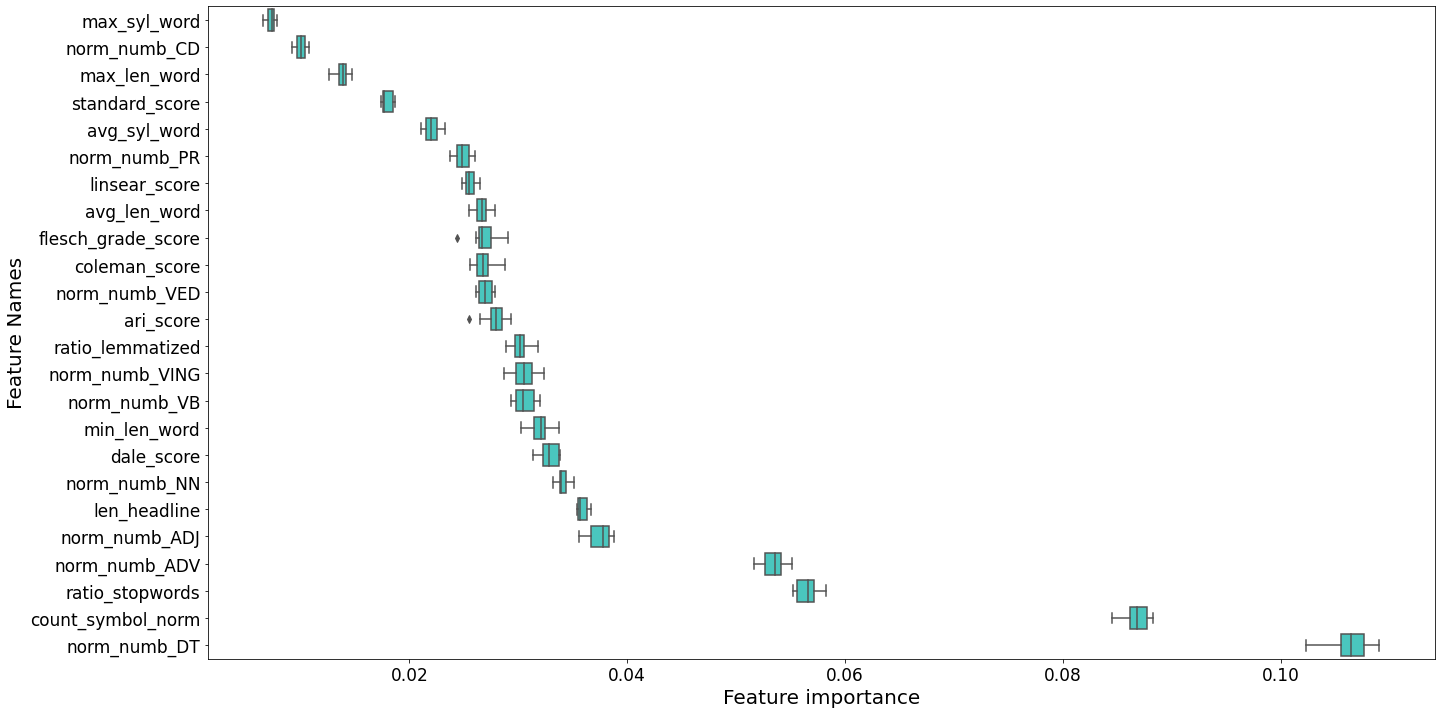

In [25]:
plt.figure(figsize=(22,12))

sns.boxplot(data=ft_imp_df, orient="h", color="#35dbd0")
plt.xlabel('Feature importance', fontsize=20)
plt.ylabel('Feature Names', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('../figures/RF_Ft_Imp.png', bbox_inches='tight', transparent=False, dpi=350)
# Show the plot
plt.show()

## Logistic Regression

In [34]:
X_train_f_norm, _, _ = normalize_data(X_train_f, [], [])

hypara = {
    'penalty': ['l1', 'l2'],
    'C': [10, 20, 30, 40, 50],
}

model_cv_lr = GridSearchCV(LogisticRegression(max_iter=2000, tol=1e-5, solver='saga', random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_lr.fit(X_train_f_norm, y_train_f);
print(f"Best CV Score: {model_cv_lr.best_score_}")
print(f"Best paras: {model_cv_lr.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


Best CV Score: 0.6978198432655167
Best paras: {'C': 10, 'penalty': 'l1'}


/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [35]:
X_train_norm, x_mean, x_std = normalize_data(X_train, [], [])
X_val_norm, _, _ = normalize_data(X_val, x_mean, x_std)


hypara = {
    'penalty': 'l1',
    'C': 10,
    'max_iter': 5000,
    'tol': 1e-5,
    'solver': 'saga',
    'random_state': 1509
}

model_lr = LogisticRegression(**hypara)
model_lr.fit(X_train_norm, y_train);

train_pred = model_lr.predict_proba(X_train_norm)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_lr.predict_proba(X_val_norm)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.6980956263467474, 'precision': 0.6743482309124768, 'recall': 0.7083129584352078, 'f1': 0.6909134271404722, 'tp': 5794, 'tn': 6193, 'fp': 2798, 'fn': 2386, 'auc': 0.765356051514704}
Validate Result:
{'accuracy': 0.7037037037037037, 'precision': 0.6778647031753336, 'recall': 0.7202933985330073, 'f1': 0.6984352773826459, 'tp': 1473, 'tn': 1548, 'fp': 700, 'fn': 572, 'auc': 0.7718948220205519}


## SVM

In [24]:
# SVM need normalization
X_train_f_norm, _, _ = normalize_data(X_train_f, [], [])

hypara = {
    'C': [0.1, 1, 5, 10, 20, 50]
}

model_cv_svm = GridSearchCV(SVC(max_iter=10000, tol=1e-5, random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_svm.fit(X_train_f_norm, y_train_f);
print(f"Best CV Score: {model_cv_svm.best_score_}")
print(f"Best paras: {model_cv_svm.best_params_}")

[10.04607715  0.01744879  0.21414481  0.26219142  2.17005218  9.47647223
  5.2931261   3.03158777  1.56733191  6.87450149  9.04673873 11.50190645
  5.30590757  8.63816949  7.6771804   0.41238513  0.03349773  0.10202515
  0.03292514  0.22984578  0.04233041  0.04136632  0.01851094  0.02594399]
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


Best CV Score: 0.7273574702440457
Best paras: {'C': 1}


/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [29]:
# SVM need normalization
X_train_norm, x_mean, x_std = normalize_data(X_train, [], [])
X_val_norm, _, _ = normalize_data(X_val, x_mean, x_std)

hypara = {
    'C': 1,
    'random_state': 1509,
    'max_iter':50000,
    'tol' : 1e-5
}
model_svm = SVC(**hypara, probability=True)
model_svm.fit(X_train_norm, y_train);

train_pred = model_svm.predict_proba(X_train_norm)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_svm.predict_proba(X_val_norm)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.7682138489313377, 'precision': 0.7556610664718773, 'recall': 0.75880195599022, 'f1': 0.7572282542393558, 'tp': 6207, 'tn': 6984, 'fp': 2007, 'fn': 1973, 'auc': 0.8500696431285945}
Validate Result:
{'accuracy': 0.7370137433030515, 'precision': 0.726061204343534, 'recall': 0.7193154034229828, 'f1': 0.7226725620240727, 'tp': 1471, 'tn': 1693, 'fp': 555, 'fn': 574, 'auc': 0.8060060994179015}


## MLP
This part use the built-in class of scikit-learn (hence just basic structure)

In [32]:
X_train_f_norm, _, _ = normalize_data(X_train_f, [], [])

hypara = {
    'hidden_layer_sizes': 1,
    'learning_rate_init': [0.005, 0.001, 0.01, 0.05],
    
}

model_cv_mlp = GridSearchCV(MLPClassifier(max_iter=2000, random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_mlp.fit(X_train_f_norm, y_train_f);
print(f"Best OOB Score: {model_cv_mlp.best_score_}")
print(f"Best paras: {model_cv_mlp.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.6s finished


Best OOB Score: 0.7319229227058331
Best paras: {'hidden_layer_sizes': (16,), 'learning_rate_init': 0.005}


In [33]:
# SVM need normalization
X_train_norm, x_mean, x_std = normalize_data(X_train, [], [])
X_val_norm, _, _ = normalize_data(X_val, x_mean, x_std)

hypara = {
    'hidden_layer_sizes': (16,),
    'learning_rate_init': 0.005,
}
model_mlp = MLPClassifier(**hypara, max_iter=2000, random_state=1509)
model_mlp.fit(X_train_norm, y_train);

train_pred = model_mlp.predict_proba(X_train_norm)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_mlp.predict_proba(X_val_norm)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.7498107273892027, 'precision': 0.7363680623174295, 'recall': 0.7396088019559902, 'f1': 0.7379848743595999, 'tp': 6050, 'tn': 6825, 'fp': 2166, 'fn': 2130, 'auc': 0.8311534843727183}
Validate Result:
{'accuracy': 0.7246680642907058, 'precision': 0.7110024449877751, 'recall': 0.7110024449877751, 'f1': 0.7110024449877751, 'tp': 1454, 'tn': 1657, 'fp': 591, 'fn': 591, 'auc': 0.8029846687955171}


## Feature selection with Logistic Regression
Run Logistic regression with L1 loss to check which features having coefficient as 0 making them became less useful and can be eliminated. However none of them have 0!

In [34]:
hypara = {
    'penalty': ['l1'],
    'C': [1, 5, 10, 20, 30, 40, 50],
}

model_cv_lr = GridSearchCV(LogisticRegression(max_iter=2000, tol=1e-5, solver='saga', random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_lr.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_lr.best_score_}")
print(f"Best paras: {model_cv_lr.best_params_}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   58.8s finished


Best CV Score: 0.6839826705907817
Best paras: {'C': 20, 'penalty': 'l1'}


/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [38]:
X_train_norm, x_mean, x_std = normalize_data(X_train, [], [])
X_val_norm, _, _ = normalize_data(X_val, x_mean, x_std)


hypara = {
    'penalty': 'l1',
    'C': 10,
    'max_iter': 5000,
    'tol': 1e-5,
    'solver': 'saga',
    'random_state': 1509
}

model_lr = LogisticRegression(**hypara)
model_lr.fit(X_train_norm, y_train);

train_pred = model_lr.predict_proba(X_train_norm)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_lr.predict_proba(X_val_norm)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.6980956263467474, 'precision': 0.6743482309124768, 'recall': 0.7083129584352078, 'f1': 0.6909134271404722, 'tp': 5794, 'tn': 6193, 'fp': 2798, 'fn': 2386, 'auc': 0.765356051514704}
Validate Result:
{'accuracy': 0.7037037037037037, 'precision': 0.6778647031753336, 'recall': 0.7202933985330073, 'f1': 0.6984352773826459, 'tp': 1473, 'tn': 1548, 'fp': 700, 'fn': 572, 'auc': 0.7718948220205519}


In [46]:
# Logistic regression coefficient
imp_word_idx = list(np.argsort(np.abs(model_lr.coef_[0]))[::-1])

In [47]:
values = model_lr.coef_[0][imp_word_idx]
labels = np.asarray(feature_names)[imp_word_idx]
values

array([ 5.09517654, -4.85841987, -1.31408215, -1.06862329,  0.86270645,
       -0.61646543, -0.53866337, -0.44428294,  0.34963795, -0.29535175,
        0.28947385,  0.28833098,  0.28712512, -0.2297851 , -0.18486482,
        0.17865078, -0.15272407,  0.124895  ,  0.10939153, -0.08837382,
       -0.06434122,  0.05604005,  0.04307724, -0.0377157 ])

In [48]:
labels

array(['ari_score', 'avg_len_word', 'len_headline', 'count_symbol_norm',
       'avg_syl_word', 'norm_numb_DT', 'coleman_score',
       'flesch_grade_score', 'norm_numb_ADV', 'ratio_stopwords',
       'norm_numb_VED', 'norm_numb_VING', 'norm_numb_ADJ', 'dale_score',
       'max_syl_word', 'max_len_word', 'norm_numb_PR', 'norm_numb_VB',
       'norm_numb_NN', 'standard_score', 'norm_numb_CD', 'linsear_score',
       'min_len_word', 'ratio_lemmatized'], dtype='<U18')

# Embedding Features - BOW
BOW embedding features. Try on both original sentences and lemmatised headlines. This section has feature selection with Logistic Regression to find useless words that having coefficients of 0 (can be discarded)

In [2]:
data_full = pd.read_json('fake_news.json', lines=True)
data_full = data_full.drop(columns=['article_link']) # remove link column
df_train_f, df_test = split_dataframe(data_full, test_size=0.25, seed=1509)
df_train, df_validate = split_dataframe(df_train_f, test_size=0.2, seed=1309)

# Proportion of each subsets
list_label = df_train['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TRAINING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_validate['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== VALIDATING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_test['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TESTING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

data_train = df_train.copy()
data_train_f = df_train_f.copy()
data_val = df_validate.copy()
data_test = df_test.copy()

data_train = df_train
data_train['headline'] = data_train.headline.apply(lambda row: row.lower())
data_train['headline_s1'] = data_train.headline.apply(lambda row: remove_symbol(row))
data_train['headline_s2'] = data_train.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_train['headline_s2'] = data_train.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))
#data_train = data_train.drop(columns=['headline', 'headline_s1'])

data_train_f = df_train_f
data_train_f['headline'] = data_train_f.headline.apply(lambda row: row.lower())
data_train_f['headline_s1'] = data_train_f.headline.apply(lambda row: remove_symbol(row))
data_train_f['headline_s2'] = data_train_f.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_train_f['headline_s2'] = data_train_f.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))

data_val = df_validate
data_val['headline'] = data_val.headline.apply(lambda row: row.lower())
data_val['headline_s1'] = data_val.headline.apply(lambda row: remove_symbol(row))
data_val['headline_s2'] = data_val.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_val['headline_s2'] = data_val.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))
#data_val = data_val.drop(columns=['headline', 'headline_s1'])

data_test = df_test
data_test['headline'] = data_test.headline.apply(lambda row: row.lower())
data_test['headline_s1'] = data_test.headline.apply(lambda row: remove_symbol(row))
data_test['headline_s2'] = data_test.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_test['headline_s2'] = data_test.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))

===== TRAINING SAMPLES =====
Total Sample: 17171
Sarcastic: 8180 (47.64%)
Not Sarcastic: 8991 (52.36%)
===== VALIDATING SAMPLES =====
Total Sample: 4293
Sarcastic: 2045 (47.64%)
Not Sarcastic: 2248 (52.36%)
===== TESTING SAMPLES =====
Total Sample: 7155
Sarcastic: 3409 (47.65%)
Not Sarcastic: 3746 (52.35%)


## Raw Sentence
Also have feature selection with Logistic Regression in this section

In [3]:
vectorizer = CountVectorizer(tokenizer=lambda text: text.split())
all_string = data_train.headline_s1.tolist()

# tokenize and build vocab
vectorizer.fit(all_string)

vocab = {k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])}
vocab = list(vocab)

# encode document
X_train_f = vectorizer.transform(data_train_f.headline_s1.tolist())
y_train_f = data_train_f.is_sarcastic.to_numpy()

X_train = vectorizer.transform(data_train.headline_s1.tolist())
y_train = data_train.is_sarcastic.to_numpy()

X_val = vectorizer.transform(data_val.headline_s1.tolist())
y_val = data_val.is_sarcastic.to_numpy()

/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### Logistic Regression

In [4]:
## LR
hypara = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 5, 10, 20],
}

model_cv_lr = GridSearchCV(LogisticRegression(max_iter=5000, tol=1e-4, solver='liblinear', random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_lr.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_lr.best_score_}")
print(f"Best paras: {model_cv_lr.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.3s finished


Best CV Score: 0.8454159212346157
Best paras: {'C': 1, 'penalty': 'l2'}


In [5]:
## LR
hypara = {
    'penalty': 'l2',
    'C': 1,
    'max_iter': 5000,
    'tol': 1e-5,
    'solver': 'liblinear',
    'random_state': 1509
}

model_lr = LogisticRegression(**hypara)
model_lr.fit(X_train, y_train);

train_pred = model_lr.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_lr.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.9721041290548017, 'precision': 0.9735579879473619, 'recall': 0.9677261613691932, 'f1': 0.9706333149408375, 'tp': 7916, 'tn': 8776, 'fp': 215, 'fn': 264, 'auc': 0.9947238327705593}
Validate Result:
{'accuracy': 0.8474260423945958, 'precision': 0.8420275590551181, 'recall': 0.8366748166259169, 'f1': 0.8393426539121902, 'tp': 1711, 'tn': 1927, 'fp': 321, 'fn': 334, 'auc': 0.9219143993248006}


### Random Forest

In [6]:
## RF
hypara = {
    'max_depth': [15, 20],
    'n_estimators': [300, 400, 500],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 5],
}

model_cv_rf = GridSearchCV(RandomForestClassifier(random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_rf.fit(X_train_f, y_train_f);
print(f"Best OOB Score: {model_cv_rf.best_score_}")
print(f"Best paras: {model_cv_rf.best_params_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.0min finished


Best OOB Score: 0.7631848829962037
Best paras: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}


In [7]:
hypara = {
    'random_state': 1509,
    'max_depth': 20,
    'n_estimators': 400,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
}
model_rf = RandomForestClassifier(**hypara)
model_rf.fit(X_train, y_train);


train_pred = model_rf.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_rf.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)


Train Result:
{'accuracy': 0.7798031564847708, 'precision': 0.9073902574550843, 'recall': 0.5988997555012225, 'f1': 0.7215553428087489, 'tp': 4899, 'tn': 8491, 'fp': 500, 'fn': 3281, 'auc': 0.9077895472217666}
Validate Result:
{'accuracy': 0.7579781038900536, 'precision': 0.8839694656488549, 'recall': 0.5662591687041565, 'f1': 0.6903129657228018, 'tp': 1158, 'tn': 2096, 'fp': 152, 'fn': 887, 'auc': 0.8865448450782658}


### SVM

In [8]:
hypara = {
    'C': [0.1, 1, 5, 10, 20, 50]
}

model_cv_svm = GridSearchCV(SVC(max_iter=5000, tol=1e-4, random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_svm.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_svm.best_score_}")
print(f"Best paras: {model_cv_svm.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


Best CV Score: 0.8527303707958664
Best paras: {'C': 20}


/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [9]:
hypara = {
    'C': 20,
    'random_state': 1509,
    'max_iter':5000,
    'tol' : 1e-4
}
model_svm = SVC(**hypara, probability=True)
model_svm.fit(X_train, y_train);

train_pred = model_svm.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_svm.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 8180, 'tn': 8991, 'fp': 0, 'fn': 0, 'auc': 1.0}
Validate Result:
{'accuracy': 0.8457954810156068, 'precision': 0.8466165413533835, 'recall': 0.8259168704156479, 'f1': 0.8361386138613861, 'tp': 1689, 'tn': 1942, 'fp': 306, 'fn': 356, 'auc': 0.9241927624881449}


### Feature Selection with Logistic Regression
Run LR model again with L1 to find useless words. Then I removed them and train LR again (with L1 again). The result show that the metrics remain exactly the same. 

I also train other classifiers again after remove useless words. The result slightly decrease but still acceptable

In [4]:
## LR
hypara = {
    'penalty': ['l1'],
    'C': [0.1, 1, 5, 10, 20],
}

model_cv_lr = GridSearchCV(LogisticRegression(max_iter=5000, tol=1e-4, solver='liblinear', random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_lr.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_lr.best_score_}")
print(f"Best paras: {model_cv_lr.best_params_}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best CV Score: 0.835305908814909
Best paras: {'C': 1, 'penalty': 'l1'}


[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:    1.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.6s finished


In [5]:
## LR
hypara = {
    'penalty': 'l1',
    'C': 1,
    'max_iter': 5000,
    'tol': 1e-5,
    'solver': 'liblinear',
    'random_state': 1509
}

model_lr = LogisticRegression(**hypara)
model_lr.fit(X_train, y_train);

train_pred = model_lr.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_lr.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.9157300099004135, 'precision': 0.9053582179409994, 'recall': 0.9191931540342299, 'f1': 0.9122232332423414, 'tp': 7519, 'tn': 8205, 'fp': 786, 'fn': 661, 'auc': 0.9735526072119388}
Validate Result:
{'accuracy': 0.831819240624272, 'precision': 0.8145506419400856, 'recall': 0.8376528117359413, 'f1': 0.8259402121504339, 'tp': 1713, 'tn': 1858, 'fp': 390, 'fn': 332, 'auc': 0.9104491686171461}


In [6]:
# Logistic regression coefficient
imp_word_idx = list(np.argsort(np.abs(model_lr.coef_[0]))[::-1])
values = model_lr.coef_[0][imp_word_idx]
labels = np.asarray(vocab)[imp_word_idx]

In [18]:
useless_idx = np.where(values==0)[0]
keep_idx = np.where(values!=0)[0]
discard_vocab = labels[useless_idx].tolist()
keep_vocab = labels[keep_idx].tolist()
print(f'Total vocab with 0 coefficient: {len(discard_vocab)} words')
print(f"Some example of useless vocab: {discard_vocab[:10]}")
print(f"Some example of good vocab: {keep_vocab[0:10]}")

Total vocab with 0 coefficient: 20658 words
Some example of useless vocab: ['farm', 'farenthold', 'farmer', 'fargo', 'farley', 'doorstops', 'fares', 'door', 'fark', 'farleys']
Some example of good vocab: ['onion', 'area', 'fucking', 'wondering', 'prose', 'reddit', 'subconscious', 'fuck', 'bitch', 'nation']


In [40]:
joblib.dump(keep_vocab, 'selected_vocab_s1.joblib')

['selected_vocab_s1.joblib']

In [14]:
# Train Again
vectorizer = CountVectorizer(tokenizer=lambda text: text.split())
all_string = ' '.join(keep_vocab)
# tokenize and build vocab
vectorizer.fit([all_string])

keep_vocab = {k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])}
keep_vocab = list(keep_vocab)

# encode document
X_train_f = vectorizer.transform(data_train_f.headline_s1.tolist())
y_train_f = data_train_f.is_sarcastic.to_numpy()

X_train = vectorizer.transform(data_train.headline_s1.tolist())
y_train = data_train.is_sarcastic.to_numpy()

X_val = vectorizer.transform(data_val.headline_s1.tolist())
y_val = data_val.is_sarcastic.to_numpy()

In [16]:
X_train.shape

(17171, 2457)

In [20]:
## LR
hypara = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 5, 10, 20],
}

model_cv_lr = GridSearchCV(LogisticRegression(max_iter=5000, tol=1e-4, solver='liblinear', random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_lr.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_lr.best_score_}")
print(f"Best paras: {model_cv_lr.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.8s finished


Best CV Score: 0.8682446597540938
Best paras: {'C': 5, 'penalty': 'l2'}


In [21]:
## LR
hypara = {
    'penalty': 'l2',
    'C': 5,
    'max_iter': 5000,
    'tol': 1e-5,
    'solver': 'liblinear',
    'random_state': 1509
}

model_lr = LogisticRegression(**hypara)
model_lr.fit(X_train, y_train);

train_pred = model_lr.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_lr.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.9429270281288219, 'precision': 0.9382761139517897, 'recall': 0.9421760391198044, 'f1': 0.9402220324508967, 'tp': 7707, 'tn': 8484, 'fp': 507, 'fn': 473, 'auc': 0.9866183624537332}
Validate Result:
{'accuracy': 0.8336827393431167, 'precision': 0.824159766195811, 'recall': 0.8273838630806846, 'f1': 0.8257686676427526, 'tp': 1692, 'tn': 1887, 'fp': 361, 'fn': 353, 'auc': 0.9097709237877298}


In [22]:
## RF
hypara = {
    'max_depth': [15, 20],
    'n_estimators': [300, 400, 500],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 5],
}

model_cv_rf = GridSearchCV(RandomForestClassifier(random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_rf.fit(X_train_f, y_train_f);
print(f"Best OOB Score: {model_cv_rf.best_score_}")
print(f"Best paras: {model_cv_rf.best_params_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   41.9s finished


Best OOB Score: 0.7840574363129124
Best paras: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}


In [23]:
hypara = {
    'random_state': 1509,
    'max_depth': 20,
    'n_estimators': 500,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
}
model_rf = RandomForestClassifier(**hypara)
model_rf.fit(X_train, y_train);


train_pred = model_rf.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_rf.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)


Train Result:
{'accuracy': 0.8020499679692504, 'precision': 0.7602046369870469, 'recall': 0.8537897310513447, 'f1': 0.804283986871653, 'tp': 6984, 'tn': 6788, 'fp': 2203, 'fn': 1196, 'auc': 0.8890408814138779}
Validate Result:
{'accuracy': 0.7868623340321453, 'precision': 0.7456521739130435, 'recall': 0.8386308068459658, 'f1': 0.7894131185270425, 'tp': 1715, 'tn': 1663, 'fp': 585, 'fn': 330, 'auc': 0.8663697804731616}


In [24]:
hypara = {
    'C': [0.1, 1, 5, 10, 20, 50]
}

model_cv_svm = GridSearchCV(SVC(max_iter=5000, tol=1e-4, random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_svm.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_svm.best_score_}")
print(f"Best paras: {model_cv_svm.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   48.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   48.1s finished


Best CV Score: 0.8580416243612948
Best paras: {'C': 5}


/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [25]:
hypara = {
    'C': 5,
    'random_state': 1509,
    'max_iter':5000,
    'tol' : 1e-4
}
model_svm = SVC(**hypara, probability=True)
model_svm.fit(X_train, y_train);

train_pred = model_svm.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_svm.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.9910313901345291, 'precision': 0.9844278126508933, 'recall': 0.9969437652811736, 'f1': 0.9906462585034013, 'tp': 8155, 'tn': 8862, 'fp': 129, 'fn': 25, 'auc': 0.9992170790730965}
Validate Result:
{'accuracy': 0.8346144887025391, 'precision': 0.8257686676427526, 'recall': 0.8273838630806846, 'f1': 0.8265754763067904, 'tp': 1692, 'tn': 1891, 'fp': 357, 'fn': 353, 'auc': 0.9091772964177883}


In [29]:
from deep_pytorch import *
datasetTrain = EncodingDataset(X_train.toarray(), y_train)
datasetVal = EncodingDataset(X_val.toarray(), y_val)

In [36]:
model_mlp = ModelMLP(datasetTrain=datasetTrain, datasetVal=datasetVal, batch_size=2048, optimizer_choice='adam', 
                     init_lr=0.001, layers=[X_train.shape[1], 512, 1], weight_decay=1e-3,
                     dropout=0.9, batchnorm=True, checkpoint=None, model_name='BOW_Raw_Light')
model_mlp.train(numb_epoch=50)

TRAIN FROM SCRATCH
Training 0/49
Total iteration: 9
Epoch 1/50 [16122020-003307] [SAVE]
AccVal: 0.7693920335429769
AUCVal: 0.888049034621375
Precision: 0.865557849407196
Recall: 0.6107579469680786
F1Val: 0.7161697486777903
LossVal: 0.6674820780754089
LossTrain: 0.6730867293145921
----------

Training 1/49
Total iteration: 9
Epoch 2/50 [16122020-003308] [SAVE]
AccVal: 0.8152806894945259
AUCVal: 0.9062917105343298
Precision: 0.8485523462295532
Recall: 0.7452322840690613
F1Val: 0.7935433869302214
LossVal: 0.6333475311597189
LossTrain: 0.44506992565260994
----------

Training 2/49
Total iteration: 9
Epoch 3/50 [16122020-003308] [SAVE]
AccVal: 0.8383414861402283
AUCVal: 0.9130179284601798
Precision: 0.8312898278236389
Recall: 0.8288508653640747
F1Val: 0.8300685252151679
LossVal: 0.5865205923716227
LossTrain: 0.3682912124527825
----------

Training 3/49
Total iteration: 9
Epoch 4/50 [16122020-003309] [SAVE]
AccVal: 0.8411367342184952
AUCVal: 0.9167056400038285
Precision: 0.8293861746788025
R

Epoch 30/50 [16122020-003323]
AccVal: 0.841835546238062
AUCVal: 0.916500948411628
Precision: 0.8341487050056458
Recall: 0.8337408304214478
F1Val: 0.8339446880393163
LossVal: 0.46546528736750287
LossTrain: 0.125530401037799
----------

Training 30/49
Total iteration: 9
Epoch 31/50 [16122020-003323]
AccVal: 0.8423014209177732
AUCVal: 0.9164205727014069
Precision: 0.8343108296394348
Recall: 0.8347188234329224
F1Val: 0.8345147468668794
LossVal: 0.4667538305123647
LossTrain: 0.1259064334962103
----------

Training 31/49
Total iteration: 9
Epoch 32/50 [16122020-003324]
AccVal: 0.8430002329373398
AUCVal: 0.9163497681177074
Precision: 0.8348802924156189
Recall: 0.835696816444397
F1Val: 0.8352883846870636
LossVal: 0.46822287638982135
LossTrain: 0.12323390195767085
----------

Training 32/49
Total iteration: 9
Epoch 33/50 [16122020-003324]
AccVal: 0.8425343582576287
AUCVal: 0.9162936465121944
Precision: 0.8347188234329224
Recall: 0.8347188234329224
F1Val: 0.8347188234329224
LossVal: 0.4694278339

In [38]:
dataloader = make_dalaloader(datasetTrain, batch_size=1024)
metrics = model_mlp.evaluate(dataloader)
metrics

{'accuracy': 0.9767631471667346,
 'precision': 0.97485656,
 'recall': 0.97640586,
 'f1': 0.9756305623514359,
 'tp': 7987,
 'tn': 8785,
 'fp': 206,
 'fn': 193,
 'auc': 0.9974219397338115}

## Lemmatized Sentence

In [8]:
vectorizer = CountVectorizer(tokenizer=lambda text: text.split())
all_string = data_train.headline_s2.tolist()

# tokenize and build vocab
vectorizer.fit(all_string)

vocab = {k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])}
vocab = list(vocab)

# encode document
X_train_f = vectorizer.transform(data_train_f.headline_s2.tolist())
y_train_f = data_train_f.is_sarcastic.to_numpy()

X_train = vectorizer.transform(data_train.headline_s2.tolist())
y_train = data_train.is_sarcastic.to_numpy()

X_val = vectorizer.transform(data_val.headline_s2.tolist())
y_val = data_val.is_sarcastic.to_numpy()

/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### Logistic Regression

In [9]:
## LR
hypara = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 5, 10, 20],
}

model_cv_lr = GridSearchCV(LogisticRegression(max_iter=5000, tol=1e-4, solver='liblinear', random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_lr.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_lr.best_score_}")
print(f"Best paras: {model_cv_lr.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished


Best CV Score: 0.8380546345521406
Best paras: {'C': 1, 'penalty': 'l2'}


In [10]:
## LR
hypara = {
    'penalty': 'l2',
    'C': 1,
    'max_iter': 5000,
    'tol': 1e-5,
    'solver': 'liblinear',
    'random_state': 1509
}

model_lr = LogisticRegression(**hypara)
model_lr.fit(X_train, y_train);

train_pred = model_lr.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_lr.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.9555063770310407, 'precision': 0.9539666993143977, 'recall': 0.9525672371638142, 'f1': 0.9532664546121851, 'tp': 7792, 'tn': 8615, 'fp': 376, 'fn': 388, 'auc': 0.9900906475614435}
Validate Result:
{'accuracy': 0.8346144887025391, 'precision': 0.8257686676427526, 'recall': 0.8273838630806846, 'f1': 0.8265754763067904, 'tp': 1692, 'tn': 1891, 'fp': 357, 'fn': 353, 'auc': 0.9108975976472431}


### Random Forest

In [11]:
## RF
hypara = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [200, 300, 400, 500],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 5],
}

model_cv_rf = GridSearchCV(RandomForestClassifier(random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_rf.fit(X_train_f, y_train_f);
print(f"Best OOB Score: {model_cv_rf.best_score_}")
print(f"Best paras: {model_cv_rf.best_params_}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.1min finished


Best OOB Score: 0.7650482188977092
Best paras: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 400}


In [12]:
hypara = {
    'random_state': 1509,
    'max_depth': 20,
    'n_estimators': 400,
    'min_samples_split': 7,
    'min_samples_leaf': 2,
}
model_rf = RandomForestClassifier(**hypara)
model_rf.fit(X_train, y_train);


train_pred = model_rf.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_rf.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)


Train Result:
{'accuracy': 0.783472133247918, 'precision': 0.8877302745915885, 'recall': 0.6244498777506112, 'f1': 0.7331706616908282, 'tp': 5108, 'tn': 8345, 'fp': 646, 'fn': 3072, 'auc': 0.9014643684706167}
Validate Result:
{'accuracy': 0.7654320987654321, 'precision': 0.8634453781512605, 'recall': 0.6029339853300734, 'f1': 0.7100489490354163, 'tp': 1233, 'tn': 2053, 'fp': 195, 'fn': 812, 'auc': 0.8795621644667577}


### SVM

In [13]:
hypara = {
    'C': [0.1, 1, 5, 10, 20, 50]
}

model_cv_svm = GridSearchCV(SVC(max_iter=5000, tol=1e-4, random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_svm.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_svm.best_score_}")
print(f"Best paras: {model_cv_svm.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best CV Score: 0.84499656889594
Best paras: {'C': 5}


/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [14]:
hypara = {
    'C': 5,
    'random_state': 1509,
    'max_iter':5000,
    'tol' : 1e-4
}
model_svm = SVC(**hypara, probability=True)
model_svm.fit(X_train, y_train);

train_pred = model_svm.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_svm.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.9998252868208025, 'precision': 0.9997555311086664, 'recall': 0.999877750611247, 'f1': 0.9998166371248701, 'tp': 8179, 'tn': 8989, 'fp': 2, 'fn': 1, 'auc': 0.9999999728062754}
Validate Result:
{'accuracy': 0.8397391101793618, 'precision': 0.8394197098549274, 'recall': 0.8205378973105134, 'f1': 0.8298714144411472, 'tp': 1678, 'tn': 1927, 'fp': 321, 'fn': 367, 'auc': 0.9164516788626021}


# Embedding TFIDF
TFIDF features. Try on both original sentences and lemmatised headlines.

In [10]:
data_full = pd.read_json('fake_news.json', lines=True)
data_full = data_full.drop(columns=['article_link']) # remove link column
df_train_f, df_test = split_dataframe(data_full, test_size=0.25, seed=1509)
df_train, df_validate = split_dataframe(df_train_f, test_size=0.2, seed=1309)

# Proportion of each subsets
list_label = df_train['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TRAINING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_validate['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== VALIDATING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

list_label = df_test['is_sarcastic'].tolist()
numb_total = len(list_label)
numb_sarcastic = np.sum(np.asarray(list_label))
numb_not_sarcastic = numb_total - numb_sarcastic
print(f'===== TESTING SAMPLES =====\nTotal Sample: {numb_total}\nSarcastic: {numb_sarcastic} ({np.round(numb_sarcastic/numb_total*100,2)}%)\nNot Sarcastic: {numb_not_sarcastic} ({np.round(numb_not_sarcastic/numb_total*100,2)}%)')

data_train = df_train.copy()
data_train_f = df_train_f.copy()
data_val = df_validate.copy()
data_test = df_test.copy()

data_train = df_train
data_train['headline'] = data_train.headline.apply(lambda row: row.lower())
data_train['headline_s1'] = data_train.headline.apply(lambda row: remove_symbol(row))
data_train['headline_s2'] = data_train.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_train['headline_s2'] = data_train.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))
#data_train = data_train.drop(columns=['headline', 'headline_s1'])

data_train_f = df_train_f
data_train_f['headline'] = data_train_f.headline.apply(lambda row: row.lower())
data_train_f['headline_s1'] = data_train_f.headline.apply(lambda row: remove_symbol(row))
data_train_f['headline_s2'] = data_train_f.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_train_f['headline_s2'] = data_train_f.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))

data_val = df_validate
data_val['headline'] = data_val.headline.apply(lambda row: row.lower())
data_val['headline_s1'] = data_val.headline.apply(lambda row: remove_symbol(row))
data_val['headline_s2'] = data_val.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_val['headline_s2'] = data_val.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))
#data_val = data_val.drop(columns=['headline', 'headline_s1'])

data_test = df_test
data_test['headline'] = data_test.headline.apply(lambda row: row.lower())
data_test['headline_s1'] = data_test.headline.apply(lambda row: remove_symbol(row))
data_test['headline_s2'] = data_test.headline_s1.apply(lambda row: lemmatize_word(row, 'v'))
data_test['headline_s2'] = data_test.headline_s2.apply(lambda row: lemmatize_word(row, 'n'))

===== TRAINING SAMPLES =====
Total Sample: 17171
Sarcastic: 8180 (47.64%)
Not Sarcastic: 8991 (52.36%)
===== VALIDATING SAMPLES =====
Total Sample: 4293
Sarcastic: 2045 (47.64%)
Not Sarcastic: 2248 (52.36%)
===== TESTING SAMPLES =====
Total Sample: 7155
Sarcastic: 3409 (47.65%)
Not Sarcastic: 3746 (52.35%)


## Raw Sentence

In [11]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: text.split())
all_string = data_train.headline_s1.tolist()

# tokenize and build vocab
vectorizer.fit(all_string)

vocab = {k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])}
vocab = list(vocab)

# encode document
X_train_f = vectorizer.transform(data_train_f.headline_s1.tolist())
y_train_f = data_train_f.is_sarcastic.to_numpy()

X_train = vectorizer.transform(data_train.headline_s1.tolist())
y_train = data_train.is_sarcastic.to_numpy()

X_val = vectorizer.transform(data_val.headline_s1.tolist())
y_val = data_val.is_sarcastic.to_numpy()

/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### Logistic Regression

In [12]:
## LR
hypara = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 5, 10, 20],
}

model_cv_lr = GridSearchCV(LogisticRegression(max_iter=5000, tol=1e-4, solver='liblinear', random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_lr.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_lr.best_score_}")
print(f"Best paras: {model_cv_lr.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s


Best CV Score: 0.8493293662345929
Best paras: {'C': 5, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.7s finished


In [13]:
## LR
hypara = {
    'penalty': 'l2',
    'C': 5,
    'max_iter': 5000,
    'tol': 1e-5,
    'solver': 'liblinear',
    'random_state': 1509
}

model_lr = LogisticRegression(**hypara)
model_lr.fit(X_train, y_train);

train_pred = model_lr.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_lr.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.9712888008852134, 'precision': 0.9722324609902937, 'recall': 0.967359413202934, 'f1': 0.9697898155524235, 'tp': 7913, 'tn': 8765, 'fp': 226, 'fn': 267, 'auc': 0.9944726579336739}
Validate Result:
{'accuracy': 0.8485907290938738, 'precision': 0.8348535765722516, 'recall': 0.8503667481662591, 'f1': 0.8425387596899224, 'tp': 1739, 'tn': 1904, 'fp': 344, 'fn': 306, 'auc': 0.9256408304257412}


### Random Forest

In [14]:
## RF
hypara = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [200, 300, 400, 500],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 5],
}

model_cv_rf = GridSearchCV(RandomForestClassifier(random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_rf.fit(X_train_f, y_train_f);
print(f"Best OOB Score: {model_cv_rf.best_score_}")
print(f"Best paras: {model_cv_rf.best_params_}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.5min finished


Best OOB Score: 0.7796309972952783
Best paras: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 300}


In [15]:
hypara = {
    'random_state': 1509,
    'max_depth': 20,
    'n_estimators': 300,
    'min_samples_split': 7,
    'min_samples_leaf': 2,
}
model_rf = RandomForestClassifier(**hypara)
model_rf.fit(X_train, y_train);


train_pred = model_rf.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_rf.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)


Train Result:
{'accuracy': 0.8097955855803389, 'precision': 0.8814032909034462, 'recall': 0.6941320293398533, 'f1': 0.7766379428258788, 'tp': 5678, 'tn': 8227, 'fp': 764, 'fn': 2502, 'auc': 0.9135647532890131}
Validate Result:
{'accuracy': 0.7747495923596552, 'precision': 0.855072463768116, 'recall': 0.634718826405868, 'f1': 0.7285994948077463, 'tp': 1298, 'tn': 2028, 'fp': 220, 'fn': 747, 'auc': 0.8856271045602068}


### SVM

In [16]:
hypara = {
    'C': [0.1, 1, 5, 10, 20, 50]
}

model_cv_svm = GridSearchCV(SVC(max_iter=5000, tol=1e-4, random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_svm.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_svm.best_score_}")
print(f"Best paras: {model_cv_svm.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


Best CV Score: 0.8526372609868597
Best paras: {'C': 5}


/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [17]:
hypara = {
    'C': 5,
    'random_state': 1509,
    'max_iter':5000,
    'tol' : 1e-4
}
model_svm = SVC(**hypara, probability=True)
model_svm.fit(X_train, y_train);

train_pred = model_svm.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_svm.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 8180, 'tn': 8991, 'fp': 0, 'fn': 0, 'auc': 1.0}
Validate Result:
{'accuracy': 0.8541812252504076, 'precision': 0.8462664714494875, 'recall': 0.847921760391198, 'f1': 0.8470933072789448, 'tp': 1734, 'tn': 1933, 'fp': 315, 'fn': 311, 'auc': 0.9263538793515997}


## Lemmatised

In [18]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: text.split())
all_string = data_train.headline_s2.tolist()

# tokenize and build vocab
vectorizer.fit(all_string)

vocab = {k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])}
vocab = list(vocab)

# encode document
X_train_f = vectorizer.transform(data_train_f.headline_s2.tolist())
y_train_f = data_train_f.is_sarcastic.to_numpy()

X_train = vectorizer.transform(data_train.headline_s2.tolist())
y_train = data_train.is_sarcastic.to_numpy()

X_val = vectorizer.transform(data_val.headline_s2.tolist())
y_val = data_val.is_sarcastic.to_numpy()

/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### Logistic Regression

In [19]:
## LR
hypara = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 5, 10, 20],
}

model_cv_lr = GridSearchCV(LogisticRegression(max_iter=5000, tol=1e-4, solver='liblinear', random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_lr.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_lr.best_score_}")
print(f"Best paras: {model_cv_lr.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s


Best CV Score: 0.8417352507571548
Best paras: {'C': 5, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.3s finished


In [20]:
## LR
hypara = {
    'penalty': 'l2',
    'C': 5,
    'max_iter': 5000,
    'tol': 1e-5,
    'solver': 'liblinear',
    'random_state': 1509
}

model_lr = LogisticRegression(**hypara)
model_lr.fit(X_train, y_train);

train_pred = model_lr.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_lr.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 0.957777648360608, 'precision': 0.9580926631436647, 'recall': 0.9530562347188264, 'f1': 0.9555678127106698, 'tp': 7796, 'tn': 8650, 'fp': 341, 'fn': 384, 'auc': 0.9905264813849438}
Validate Result:
{'accuracy': 0.8395061728395061, 'precision': 0.8256484149855908, 'recall': 0.8405867970660147, 'f1': 0.833050642112915, 'tp': 1719, 'tn': 1885, 'fp': 363, 'fn': 326, 'auc': 0.9145953153686189}


### Random Forest

In [21]:
## RF
hypara = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [200, 300, 400, 500],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [2, 5],
}

model_cv_rf = GridSearchCV(RandomForestClassifier(random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_rf.fit(X_train_f, y_train_f);
print(f"Best OOB Score: {model_cv_rf.best_score_}")
print(f"Best paras: {model_cv_rf.best_params_}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.2min finished


Best OOB Score: 0.780329570516081
Best paras: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 400}


In [22]:
hypara = {
    'random_state': 1509,
    'max_depth': 20,
    'n_estimators': 400,
    'min_samples_split': 7,
    'min_samples_leaf': 2,
}
model_rf = RandomForestClassifier(**hypara)
model_rf.fit(X_train, y_train);


train_pred = model_rf.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_rf.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)


Train Result:
{'accuracy': 0.8105526760235281, 'precision': 0.8675220050723557, 'recall': 0.710880195599022, 'f1': 0.7814284754417792, 'tp': 5815, 'tn': 8103, 'fp': 888, 'fn': 2365, 'auc': 0.909080868426155}
Validate Result:
{'accuracy': 0.7819706498951782, 'precision': 0.8446239900559354, 'recall': 0.6645476772616137, 'f1': 0.7438423645320197, 'tp': 1359, 'tn': 1998, 'fp': 250, 'fn': 686, 'auc': 0.8825521626395427}


### SVM

In [23]:
hypara = {
    'C': [0.1, 1, 5, 10, 20, 50]
}

model_cv_svm = GridSearchCV(SVC(max_iter=5000, tol=1e-4, random_state=1509), hypara, verbose=1, n_jobs=-1)
model_cv_svm.fit(X_train_f, y_train_f);
print(f"Best CV Score: {model_cv_svm.best_score_}")
print(f"Best paras: {model_cv_svm.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


Best CV Score: 0.84681338245641
Best paras: {'C': 5}


/home/nmduy/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [24]:
hypara = {
    'C': 5,
    'random_state': 1509,
    'max_iter':5000,
    'tol' : 1e-4
}
model_svm = SVC(**hypara, probability=True)
model_svm.fit(X_train, y_train);

train_pred = model_svm.predict_proba(X_train)
train_pred = train_pred[:,1]
metrics = calculate_metric(y_train, train_pred)
print('Train Result:')
print(metrics)

val_pred = model_svm.predict_proba(X_val)
val_pred = val_pred[:,1]
metrics = calculate_metric(y_val, val_pred)
print('Validate Result:')
print(metrics)

Train Result:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tp': 8180, 'tn': 8991, 'fp': 0, 'fn': 0, 'auc': 1.0}
Validate Result:
{'accuracy': 0.8439319822967621, 'precision': 0.8316449589966233, 'recall': 0.8430317848410758, 'f1': 0.8372996600291405, 'tp': 1724, 'tn': 1899, 'fp': 349, 'fn': 321, 'auc': 0.919422861070748}
